In [1]:
import xarray as xr
import numpy as np
from osgeo import ogr, osr
from datetime import datetime
import matplotlib.pylab as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.dates import MonthLocator, YearLocator
matplotlib.use('nbAgg')
import pandas as pd
from rasterstats import zonal_stats, gen_zonal_stats
from tqdm import *
# import pymannkendall as mk
from decimal import *
from matplotlib.patches import Polygon

import fiona
import rasterio
import rasterio.plot
import matplotlib as mpl
from descartes import PolygonPatch
import imageio

import sys
sys.path.insert(0,'/workspace/WorldPeatland/code/')
from gdal_sheep import *
from save_xarray_to_gtiff import *
import matplotlib.dates as mdates

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2145267/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

### Generic path 

In [4]:
site='MerBleue'

In [5]:
path = f'/wp_data/sites/{site}/MODIS/timeSeries'

#### LST

In [6]:
# linear.smoothn.descaled
path_lstDay = path + '/MYD11A1.061._LST_Day_1km.linear.smoothn.0.5.descaled.tif'

arr, dts, opn = gdal_dt(path_lstDay, 'time')
xr_lstDay = create_xarr(opn, 'LST', arr, dts)


path_lstNight = path + '/MYD11A1.061._LST_Night_1km.linear.smoothn.0.5.descaled.tif'

arr, dts, opn = gdal_dt(path_lstNight, 'time')
xr_lstNight = create_xarr(opn, 'LST', arr, dts)

In [7]:
# Actual smoothened Observations of LSTs
# Difference between day and night LST 
xr_lstDay['dif_LST'] = xr_lstDay['LST'] - xr_lstNight['LST']

In [8]:
# linear.smoothn.descaled.detrended
path_lstDayDetrended = path + '/MYD11A1.061._LST_Day_1km.linear.smoothn.0.5.descaled.detrended.tif'

arr, dts, opn = gdal_dt(path_lstDayDetrended, 'time')
xr_lstDayDetrended = create_xarr(opn, 'LST', arr, dts)

path_lstNightDetrended = path + '/MYD11A1.061._LST_Night_1km.linear.smoothn.0.5.descaled.detrended.tif'

arr, dts, opn = gdal_dt(path_lstNightDetrended, 'time')
xr_lstNightDetrended = create_xarr(opn, 'LST', arr, dts)

In [9]:
# Actual smoothened Observations of LSTs
# Difference between day and night LST 
xr_lstDayDetrended['dif_LST_detrended'] = xr_lstDayDetrended['LST'] - xr_lstNightDetrended['LST']

### Pick a point

In [10]:
lon, lat = -75.51767847518616, 45.41424678011711

In [11]:
# Create point from the lat lon 
pt = ogr.Geometry(ogr.wkbPoint)
pt.AddPoint(lon, lat)

source_srs = osr.SpatialReference()
source_srs.ImportFromProj4('+proj=longlat +datum=WGS84 +no_defs +type=crs')  # WGS84

target_srs = osr.SpatialReference()
target_srs.ImportFromProj4('+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +R=6371007.181 +units=m +no_defs')

# Create a coordinate transformation
transform = osr.CoordinateTransformation(source_srs, target_srs)

pt.Transform(transform)

lon, lat = pt.GetX(),pt.GetY()

#### PLOT

<IPython.core.display.Javascript object>


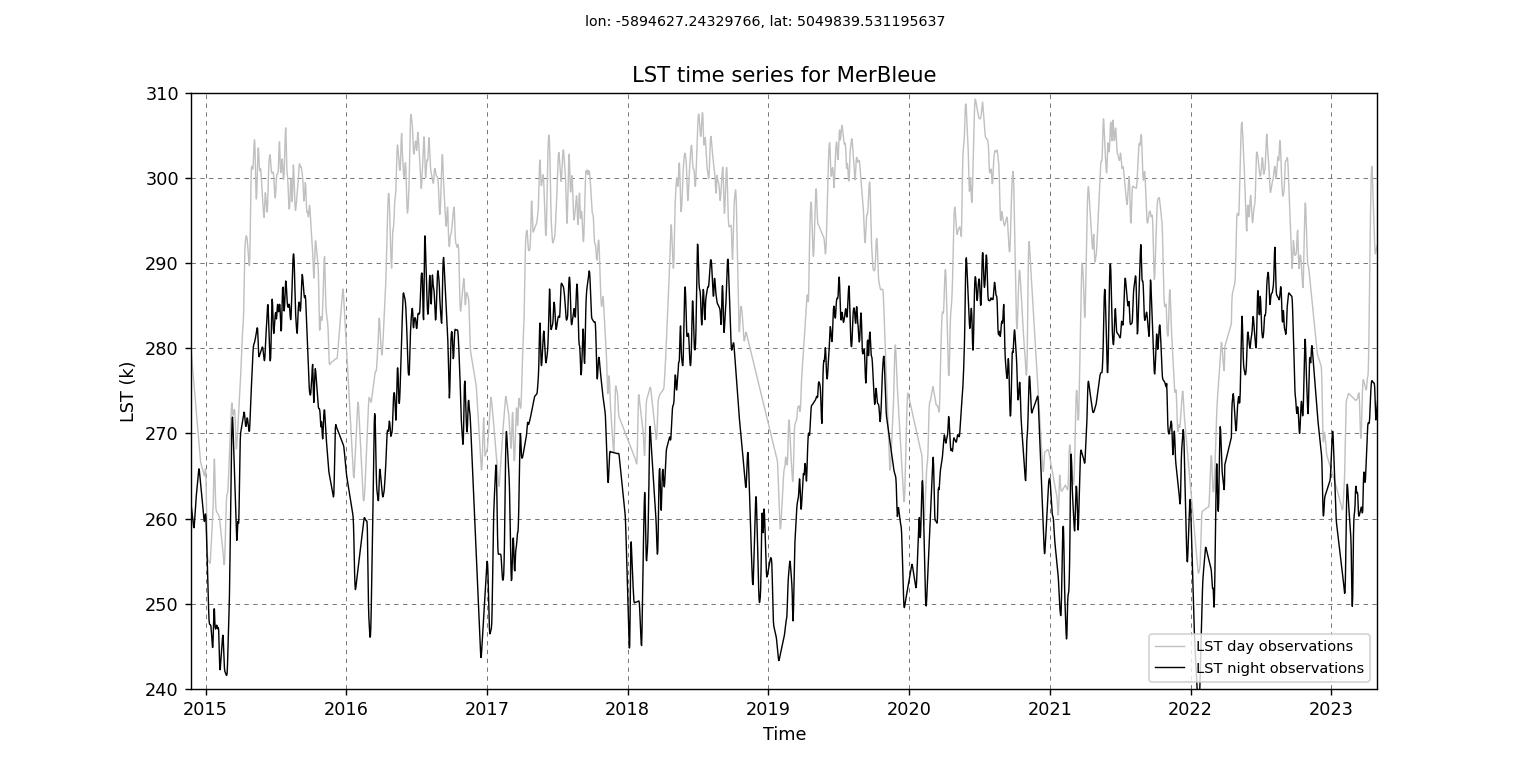

In [12]:
fig, ax = plt.subplots()

ax.plot(xr_lstDay['LST'].time.values, 
        xr_lstDay['LST'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='silver', label="LST day observations", linewidth=0.8)

ax.plot(xr_lstNight['LST'].time.values, 
        xr_lstNight['LST'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='black', label="LST night observations", linewidth=0.8)

ax.set_title(f'LST time series for {site}')
fig.suptitle(f'lon: {lon}, lat: {lat}', fontsize=8)
ax.set_xlabel('Time')
ax.set_ylabel('LST (k)')

ax.set_ylim(240, 310)
ax.set_xlim([datetime(2014, 11, 25), datetime(2023, 5, 1)])
plt.grid(linestyle=(0, (5, 5)), linewidth=0.5, color='dimgray')
ax.legend(loc='lower right', fontsize='small')

fig.savefig(f'/workspace/WorldPeatland/visualisation/ts_vis/{site}.lst.obs.png', dpi=300)

plt.show()

<IPython.core.display.Javascript object>


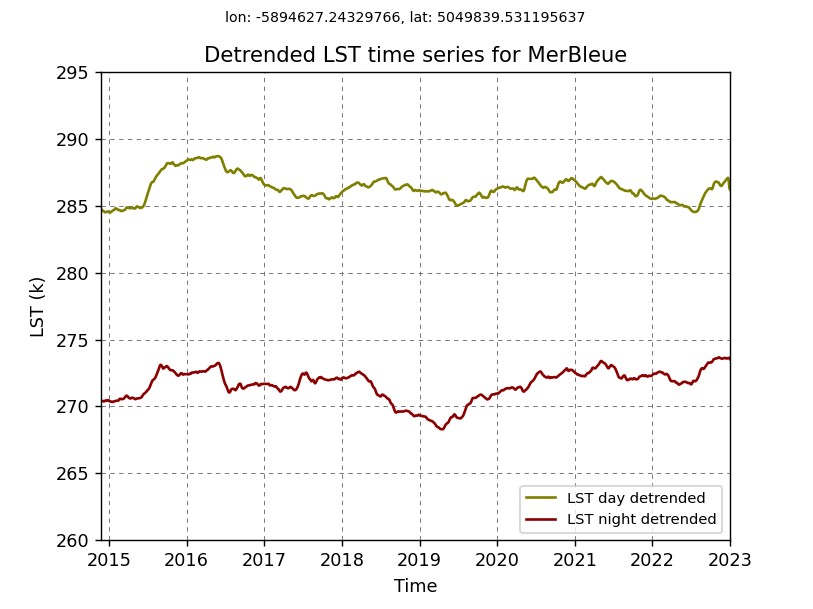

In [20]:
fig, ax = plt.subplots()

ax.plot(xr_lstDayDetrended['LST'].time.values, 
        xr_lstDayDetrended['LST'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='olive', label="LST day detrended")

ax.plot(xr_lstNightDetrended['LST'].time.values, 
        xr_lstNightDetrended['LST'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='darkred', label="LST night detrended")

ax.set_title(f'Detrended LST time series for {site}')
fig.suptitle(f'lon: {lon}, lat: {lat}', fontsize=8)
ax.set_xlabel('Time')
ax.set_ylabel('LST (k)')

ax.set_ylim(260, 295)
ax.set_xlim([datetime(2014, 11, 25), datetime(2023, 1, 1)])

plt.grid(linestyle=(0, (5, 5)), linewidth=0.5, color='dimgray')
ax.legend(loc='lower right', fontsize='small')
fig.savefig(f'/workspace/WorldPeatland/visualisation/ts_vis/{site}.lst.detrended.png', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


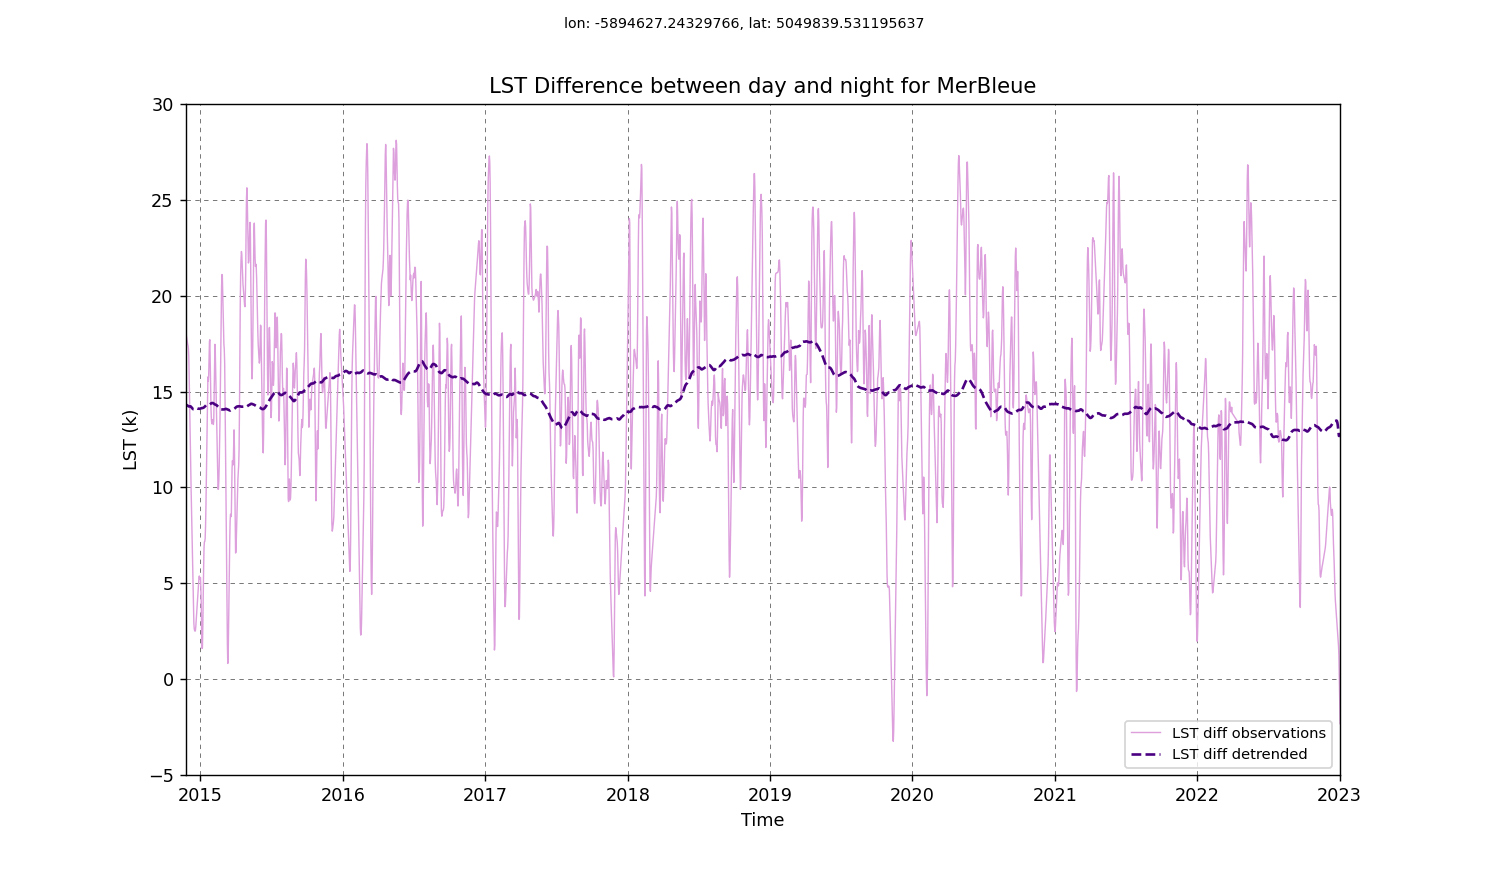

In [21]:
fig, ax = plt.subplots()

ax.plot(xr_lstDay['dif_LST'].time.values, 
        xr_lstDay['dif_LST'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='plum', label="LST diff observations", linewidth=0.8)

ax.plot(xr_lstDayDetrended['dif_LST_detrended'].time.values, 
        xr_lstDayDetrended['dif_LST_detrended'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='indigo', label="LST diff detrended",linestyle='--')

ax.set_title(f'LST Difference between day and night for {site}')
fig.suptitle(f'lon: {lon}, lat: {lat}', fontsize=8)
ax.set_xlabel('Time')
ax.set_ylabel('LST (k)')

ax.set_ylim(-5,30)
ax.set_xlim([datetime(2014, 11, 25), datetime(2023, 1, 1)])

plt.grid(linestyle=(0, (5, 5)), linewidth=0.5, color='dimgray')
ax.legend(loc='lower right', fontsize='small')
fig.savefig(f'/workspace/WorldPeatland/visualisation/ts_vis/{site}.lst.diff.png', dpi=300)
plt.show()

#### LAI

In [15]:
# linear.smoothn.descaled
path_lai = path + '/MCD15A3H.061._Lai_500m.linear.smoothn.0.5.descaled.tif'

arr, dts, opn = gdal_dt(path_lai, 'time')
xr_lai = create_xarr(opn, 'lai', arr, dts)

# linear.smoothn.descaled.detrended
path_laiDetrended = path + '/MCD15A3H.061._Lai_500m.linear.smoothn.0.5.descaled.detrended.tif'

arr, dts, opn = gdal_dt(path_laiDetrended, 'time')
xr_laiDetrended = create_xarr(opn, 'lai', arr, dts)

<IPython.core.display.Javascript object>


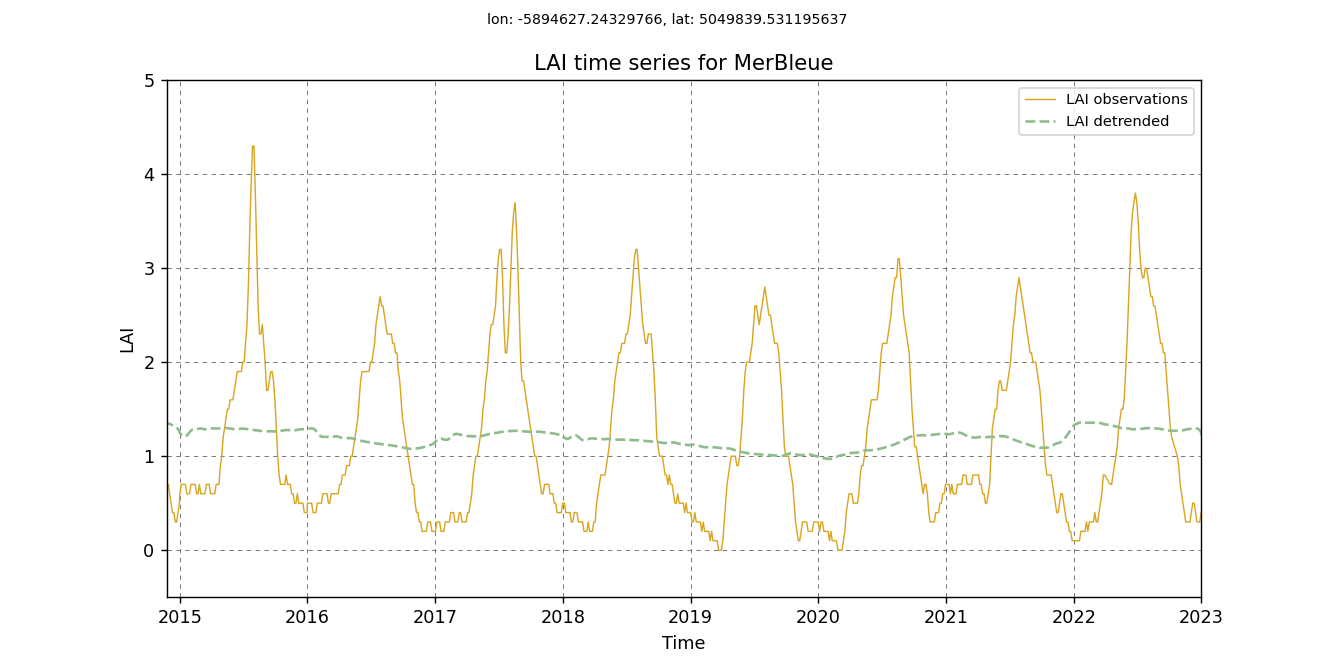

In [23]:
fig, ax = plt.subplots()

ax.plot(xr_lai['lai'].time.values, 
        xr_lai['lai'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='goldenrod', label="LAI observations", linewidth=0.8)

ax.plot(xr_laiDetrended['lai'].time.values, 
        xr_laiDetrended['lai'].sel(latitude=lat, longitude=lon, method='nearest').data,
       color='darkseagreen', label="LAI detrended",linestyle='--')

ax.set_title(f'LAI time series for {site}')
fig.suptitle(f'lon: {lon}, lat: {lat}', fontsize=8)
ax.set_xlabel('Time')
ax.set_ylabel('LAI')

ax.set_ylim(-0.5,5)
ax.set_xlim([datetime(2014, 11, 25), datetime(2023, 1, 1)])

plt.grid(linestyle=(0, (5, 5)), linewidth=0.5, color='dimgray')
ax.legend(loc='upper right', fontsize='small')
fig.savefig(f'/workspace/WorldPeatland/visualisation/ts_vis/{site}.lai.png', dpi=300)
plt.show()